In [1]:
%matplotlib inline

In [2]:
from matplotlib import pyplot as plt
import numpy as np
import os
from PIL import Image
import tensorflow as tf
import math
from skimage.transform import resize
from copy import deepcopy
from matplotlib import colors as mcolors
from colormath.color_objects import sRGBColor, LabColor
from colormath.color_conversions import convert_color
from colormath.color_diff import delta_e_cie2000
from sklearn.cluster import KMeans
from colormath.color_objects import sRGBColor, LabColor
from colormath.color_conversions import convert_color
from colormath.color_diff import delta_e_cie2000
from sklearn.cluster import KMeans

/Users/aghasy/.pyenv/versions/3.6.0/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [3]:
!bazel build -c opt //im2txt/...

.................
Loading: 
Loading: 0 packages loaded
Loading: 3 packages loaded
Analyzing: 17 targets (5 packages loaded)
Analyzing: 17 targets (6 packages loaded)
Analyzing: 17 targets (7 packages loaded)
Analyzing: 17 targets (8 packages loaded)
Analyzing: 17 targets (17 packages loaded)
Analyzing: 17 targets (17 packages loaded)
Analyzing: 17 targets (17 packages loaded)
Analyzing: 17 targets (17 packages loaded)
Analyzing: 17 targets (17 packages loaded)
    currently loading: @local_config_xcode//
Analyzing: 17 targets (19 packages loaded)
    currently loading: @bazel_tools//tools/coverage
INFO: Analysed 17 targets (20 packages loaded).
Building: no action
INFO: Found 17 targets...
Building: no action
[0 / 0] no action
INFO: Elapsed time: 5.566s, Critical Path: 0.02s
[25 / 25] no action
INFO: Build completed successfully, 1 total action


In [4]:
import sys
import collections

In [5]:
sys.path.insert(0, 'bazel-bin/im2txt/run_inference.runfiles/im2txt/')

In [6]:
from __future__ import absolute_import
from im2txt import configuration
from im2txt.inference_utils import caption_generator
from im2txt.inference_utils import vocabulary
from im2txt import show_and_tell_model
from im2txt.inference_utils import inference_wrapper_base

In [7]:
tf.logging.set_verbosity(tf.logging.INFO)

In [8]:
checkpoint_path = '/Users/aghasy/GoogleDrive/SCI/PHD/demo/im2txt+ssd/3/model.ckpt-1000000'

In [9]:
class InferenceWrapper(inference_wrapper_base.InferenceWrapperBase):
    """Model wrapper class for performing inference with a ShowAndTellModel."""

    def __init__(self):
        super(InferenceWrapper, self).__init__()
        self.fetches = {}
        self.post_feed_image = lambda: result 
    
    def build_model(self, model_config):
        model = show_and_tell_model.ShowAndTellModel(model_config, mode="inference")
        model.build()
        return model
    
    
    
    def feed_image(self, sess, encoded_image):
        self.fetches['initial_state'] = tf.get_default_graph().get_tensor_by_name('lstm/initial_state:0')
        result = sess.run(fetches=self.fetches,
                                 feed_dict={"image_feed:0": encoded_image})
        self.post_feed_image(result)
        return result['initial_state']

    def inference_step(self, sess, input_feed, state_feed):
        softmax_output, state_output = sess.run(
            fetches=["softmax:0", "lstm/state:0"],
            feed_dict={
                "input_feed:0": input_feed,
                "lstm/state_feed:0": state_feed,
            })
        return softmax_output, state_output, None


In [10]:
from im2txt.ops import image_embedding
image_embedding.batch_size = 1
model = InferenceWrapper()
config = configuration.ModelConfig()
restore_fn = model.build_graph_from_config(config, checkpoint_path)

INFO:tensorflow:Building model.
batch_size=1


In [11]:
def test_uninitialized(sess):
    global_vars          = tf.global_variables()
    is_not_initialized   = sess.run([tf.is_variable_initialized(var) for var in global_vars])
    not_initialized_vars = [v for (v, f) in zip(global_vars, is_not_initialized) if not f]
    if not_initialized_vars:
        print ('Not initalized varibles are: ', [str(i.name) for i in not_initialized_vars])
        # from tensorflow.python.tools.inspect_checkpoint import print_tensors_in_checkpoint_file
        # print_tensors_in_checkpoint_file(checkpoint_path, all_tensors=True, tensor_name='')
    assert not not_initialized_vars

In [12]:
from tensorflow.python.framework import graph_util

In [13]:
output_node_names = [
    'detection_boxes', 
    'detection_classes', 
    'detection_scores', 
    'num_detections', 
    'softmax', 
    'lstm/state',
    'lstm/initial_state'
]

In [14]:
with tf.Session() as sess:
    restore_fn(sess)
    test_uninitialized(sess)
    output_graph_def = graph_util.convert_variables_to_constants(
        sess,
        tf.get_default_graph().as_graph_def(),
        output_node_names)

INFO:tensorflow:Loading model from checkpoint: /Users/aghasy/GoogleDrive/SCI/PHD/demo/im2txt+ssd/3/model.ckpt-1000000
INFO:tensorflow:Restoring parameters from /Users/aghasy/GoogleDrive/SCI/PHD/demo/im2txt+ssd/3/model.ckpt-1000000
INFO:tensorflow:Successfully loaded checkpoint: model.ckpt-1000000
INFO:tensorflow:Froze 24 variables.
INFO:tensorflow:Converted 24 variables to const ops.


In [15]:
with open(checkpoint_path+'_freezed.pb', 'wb') as f:
    f.write(output_graph_def.SerializeToString())

In [16]:
sys.path.insert(0, '..')
sys.path.insert(0, '../slim/')

In [17]:
from object_detection.utils import ops as utils_ops

In [18]:
!cd ..; protoc object_detection/protos/*.proto --python_out=.

In [19]:
sys.path.insert(0, '../object_detection')
from utils import label_map_util
from utils import visualization_utils as vis_util

../object_detection/utils/visualization_utils.py:25: UserWarning: matplotlib.pyplot as already been imported, this call will have no effect.
  import matplotlib; matplotlib.use('Agg')  # pylint: disable=multiple-statements


In [20]:
PATH_TO_LABELS = os.path.abspath('../object_detection/data/mscoco_label_map.pbtxt')
NUM_CLASSES = 90

In [21]:
label_map  = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

In [23]:
TEST_IMAGES_DIR = '/Users/aghasy/Desktop/tmp/test_images/'
TEST_IMAGE_PATHS =lambda : [os.path.join(TEST_IMAGES_DIR, x) for x in  os.listdir(TEST_IMAGES_DIR)]
IMAGE_SIZE = (12, 8)

In [24]:
image_tensor = tf.get_default_graph().get_tensor_by_name('image_feed:0')

In [25]:
def get_detection_tensors():
    ops = tf.get_default_graph().get_operations()
    all_tensor_names = {output.name for op in ops for output in op.outputs}
    tensor_dict = {}
    for key in [
            'num_detections', 'detection_boxes', 'detection_scores',
            'detection_classes', 'detector_image', 'decode/DecodeJpeg'
    ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
            tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
                    tensor_name)
    return tensor_dict

In [26]:
vocab_file = '/Users/aghasy/tmp/im2sem/model/word_counts.txt'
vocab = vocabulary.Vocabulary(vocab_file)
generator = caption_generator.CaptionGenerator(model, vocab)

INFO:tensorflow:Initializing vocabulary from file: /Users/aghasy/tmp/im2sem/model/word_counts.txt
INFO:tensorflow:Created vocabulary with 11520 words


In [27]:
color_map = [(convert_color(sRGBColor(*(mcolors.to_rgba(color)[:3])), LabColor), name) 
             for name, color in mcolors.CSS4_COLORS.items()]

In [99]:
def lab2rgb(lab):
    return convert_color(LabColor(*lab), sRGBColor).get_value_tuple()

def rgb2lab(rgb):
    return convert_color(sRGBColor(*rgb), LabColor).get_value_tuple()

def lab2rgb_np(lab):
    return np.array([lab2rgb(x) for x in lab.reshape([-1, 3])]).reshape(lab.shape)

def rgb2lab_np(rgb):
    return np.array([rgb2lab(x) for x in rgb.reshape([-1, 3])]).reshape(rgb.shape)

In [144]:
def get_dominant_color(image, rect):
    c = (rect * [image.shape[:2] * 2]).astype(np.int).flatten()
    w = c[2] - c[0]
    h = c[3] - c[1]
    zw = w // 4
    zh = h // 4
    c = c + [zw, zh, -zw, -zh]
    
    subimg = image[c[0]:c[2], c[1]:c[3]]
    subimg100 = resize(subimg/255.0, (100, 100), anti_aliasing=False, mode='reflect', order=3)
    subimg100f = subimg100.reshape([-1, 3])
    subimg100f = rgb2lab_np(subimg100f)
#     subimg100f[:, 0] = 0.8 * subimg100f[:, 0] + 0.2 * np.median(subimg100f[:,0])
    kmeanks = KMeans(n_clusters=9).fit(subimg100f)
    labels = list(kmeanks.labels_)
    palette_info = list(sorted([(r, labels.count(r)) 
                                for r in range(kmeanks.n_clusters)], key=lambda i: -i[1]))
    print(palette_info)
    palette = [x for x, _ in palette_info]
    plt.figure(figsize=IMAGE_SIZE)
    plt.subplot(131)
    plt.imshow(subimg100)
    plt.subplot(132)
    palette = lab2rgb_np(kmeanks.cluster_centers_[palette])
    plt.imshow(palette.reshape(3,3,3))

    
    dominant_color = palette[0]
    plt.subplot(133)
    plt.imshow([[dominant_color]])
    
    plt.draw()
    plt.pause(0.1)
    dominant_lab = convert_color(sRGBColor(*dominant_color), LabColor)
    return min(color_map, key=lambda p: delta_e_cie2000(dominant_lab, p[0]))[1]

In [145]:
max_boxes_to_draw = 20
min_score_thresh = 0.5

def draw_detection_result(output_dict):
    # all outputs are float32 numpy arrays, so convert types as appropriate
    image_np = output_dict['decode/DecodeJpeg']
    # Visualization of the results of a detection.
    image_np = np.array(image_np).astype(np.uint8)[:,:,:3]
    detection_boxes = output_dict['detection_boxes'][0]
    detection_classes = output_dict['detection_classes'][0].astype(np.uint8)
    detection_scores = output_dict['detection_scores'][0]
    
    labels = zip(*list(sorted(
        filter(lambda i: i[2] >= min_score_thresh,  
               zip(detection_boxes, detection_classes, detection_scores)),
        key=lambda i: -i[2]))[:max_boxes_to_draw])
    labels = list(labels)
    STANDARD_COLORS = deepcopy(vis_util.STANDARD_COLORS)
    if len(labels):
        lcategory_index = deepcopy(category_index)
        skeepides = [1]
        detection_boxes, detection_classes, detection_scores = labels
        detection_boxes, detection_classes, detection_scores = np.array(detection_boxes), np.array(detection_classes), np.array(detection_scores),
        lid = len(lcategory_index);
        for i in range(len(detection_boxes)):
            c = detection_classes[i]
            if c in skeepides:
                continue
            color = get_dominant_color(image_np, detection_boxes[i])
            lid += 1
            d = lcategory_index[c]
            vis_util.STANDARD_COLORS[lid % len(STANDARD_COLORS)] = color if color != 'black' else 'darkgrey'
            lcategory_index[lid] = dict(id=d['id'], name=color + ' ' + d['name'], color=color)
            detection_classes[i] = lid
        vis_util.visualize_boxes_and_labels_on_image_array(
            image_np,
            detection_boxes,
            detection_classes,
            detection_scores,
            lcategory_index,
            instance_masks=None,
            max_boxes_to_draw=max_boxes_to_draw,
            min_score_thresh=min_score_thresh,
            use_normalized_coordinates=True,
            line_thickness=min(image_np.shape[:-1]) // 100)
        vis_util.STANDARD_COLORS = STANDARD_COLORS
    plt.figure(figsize=IMAGE_SIZE)
    plt.imshow(image_np)

In [146]:
model.fetches = get_detection_tensors()
model.post_feed_image = draw_detection_result

INFO:tensorflow:Loading model from checkpoint: /Users/aghasy/GoogleDrive/SCI/PHD/demo/im2txt+ssd/3/model.ckpt-1000000
INFO:tensorflow:Restoring parameters from /Users/aghasy/GoogleDrive/SCI/PHD/demo/im2txt+ssd/3/model.ckpt-1000000
INFO:tensorflow:Successfully loaded checkpoint: model.ckpt-1000000
/Users/aghasy/Desktop/tmp/test_images/red-car_berkley_01.jpg
[(1, 3001), (2, 1879), (3, 1282), (6, 1096), (0, 1016), (5, 799), (7, 530), (8, 328), (4, 69)]


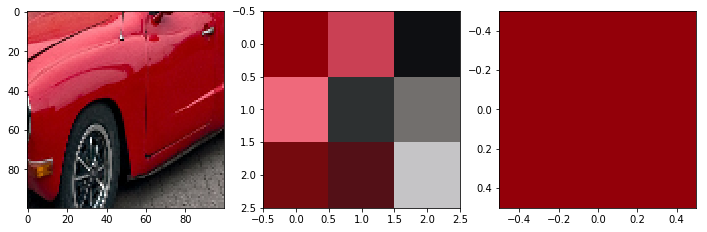

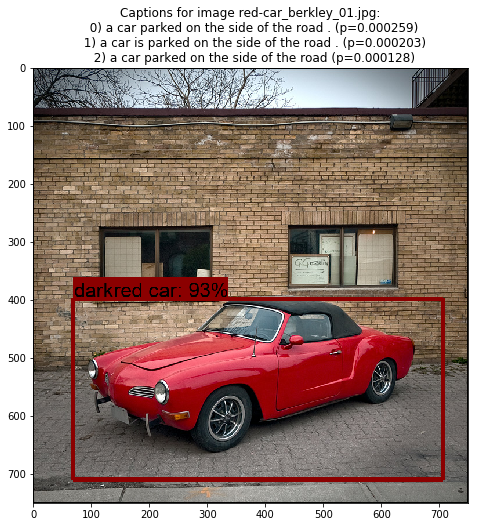

/Users/aghasy/Desktop/tmp/test_images/3848765-wallpaper-images-download.jpg
[(0, 4559), (1, 1271), (5, 901), (3, 781), (2, 654), (6, 531), (8, 446), (7, 441), (4, 416)]


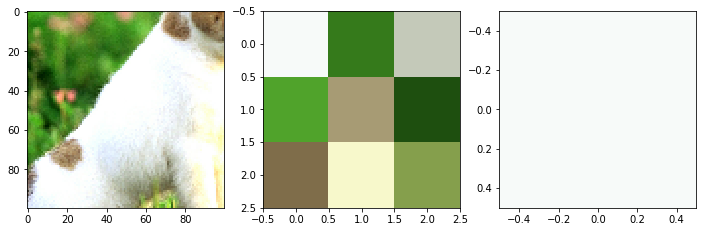

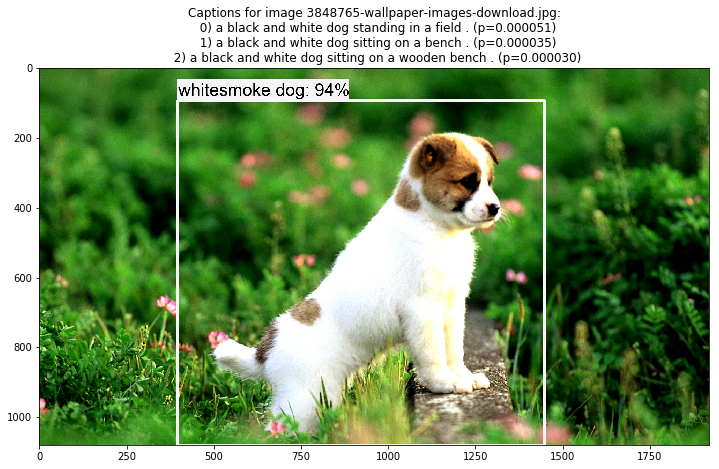

/Users/aghasy/Desktop/tmp/test_images/Untitled-1.png


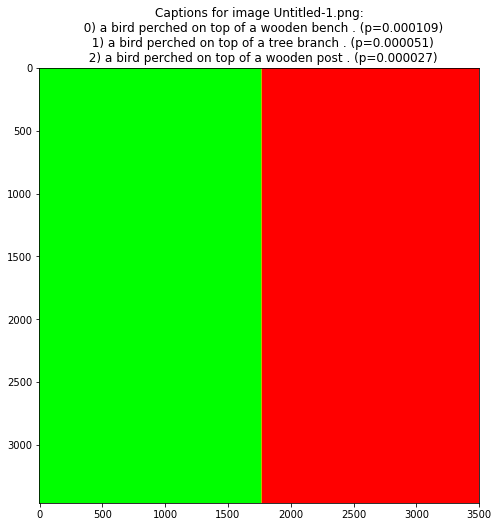

/Users/aghasy/Desktop/tmp/test_images/230237305001202.jpg


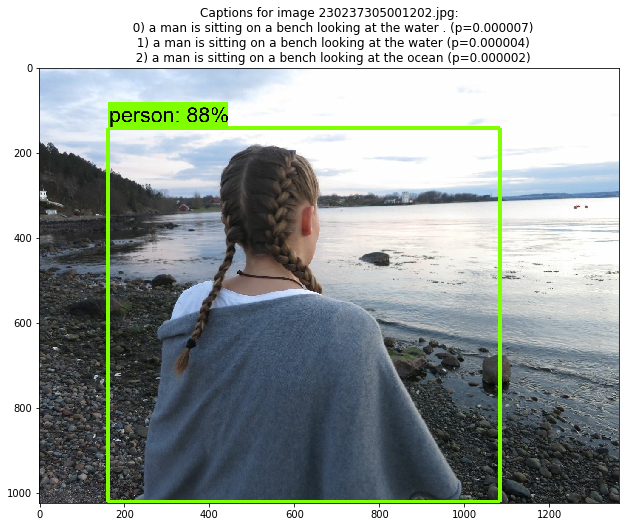

/Users/aghasy/Desktop/tmp/test_images/228584225065201.jpg
[(0, 2250), (1, 1428), (7, 1284), (8, 961), (3, 951), (4, 916), (6, 910), (5, 745), (2, 555)]


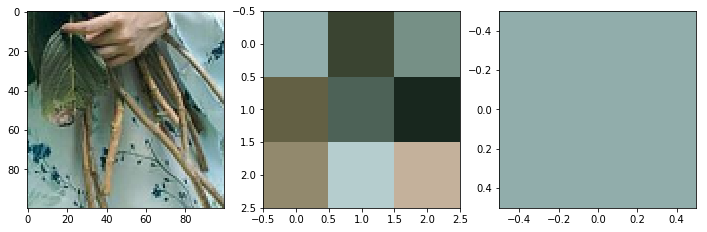

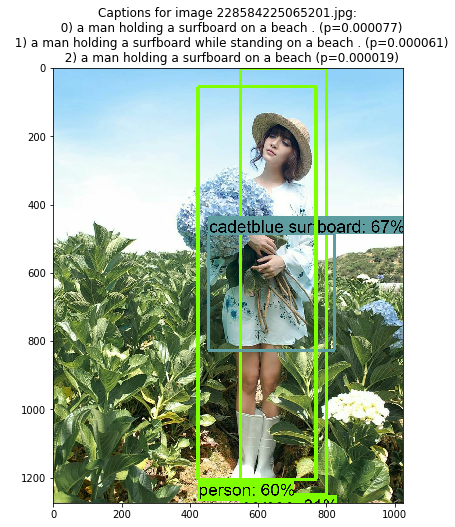

/Users/aghasy/Desktop/tmp/test_images/img_0986.jpg
[(7, 4017), (1, 2190), (6, 943), (8, 744), (0, 521), (3, 435), (5, 427), (2, 380), (4, 343)]


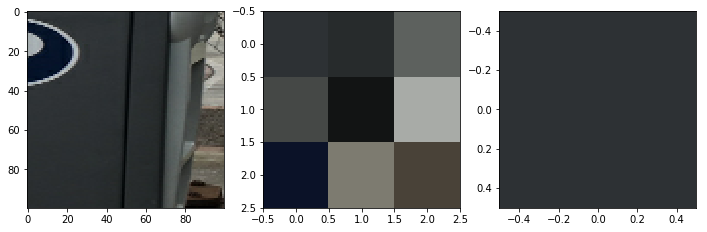

[(4, 1968), (0, 1860), (6, 1711), (8, 1569), (2, 889), (1, 743), (7, 631), (3, 520), (5, 109)]


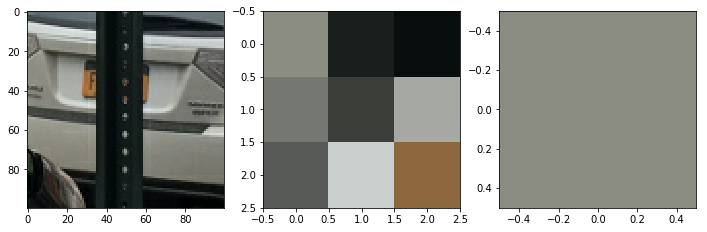

[(1, 3073), (5, 2516), (8, 2216), (4, 986), (3, 567), (0, 310), (7, 152), (2, 137), (6, 43)]


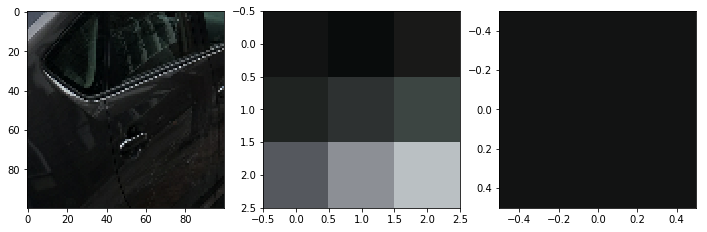

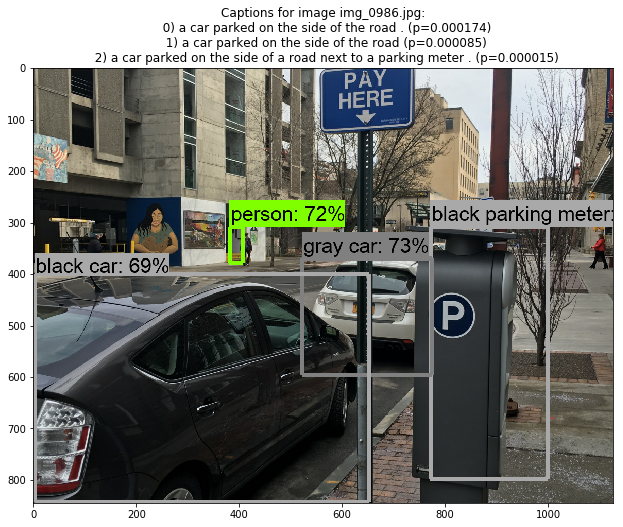

/Users/aghasy/Desktop/tmp/test_images/16239542448_2f16255fed.jpg
[(7, 1994), (4, 1644), (3, 1375), (2, 1299), (0, 1263), (1, 726), (6, 704), (8, 619), (5, 376)]


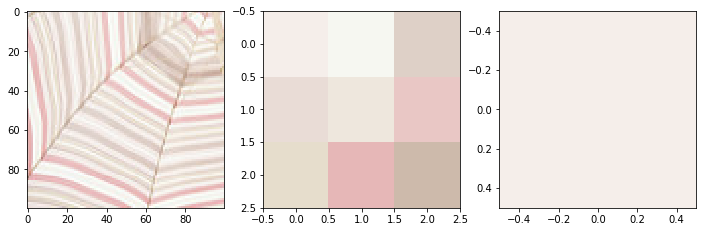

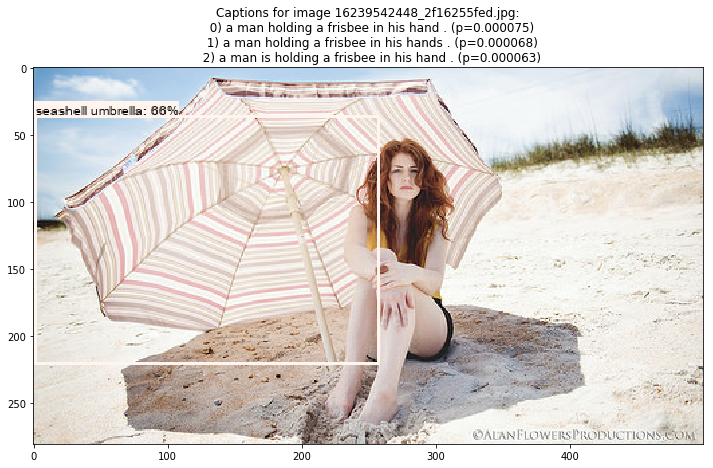

/Users/aghasy/Desktop/tmp/test_images/230486581058202.jpg


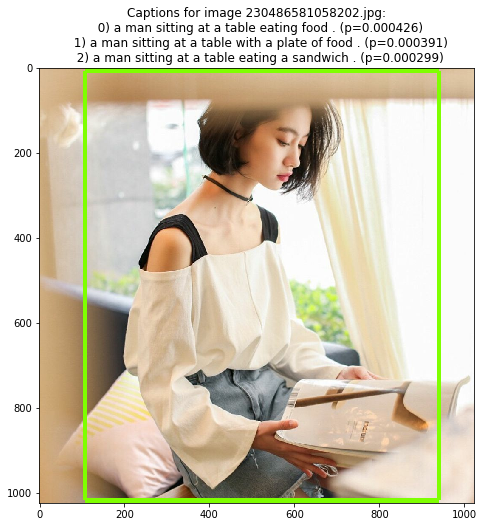

/Users/aghasy/Desktop/tmp/test_images/391895.jpg
[(0, 2037), (8, 1752), (2, 1359), (3, 1305), (1, 1017), (6, 997), (5, 796), (7, 416), (4, 321)]


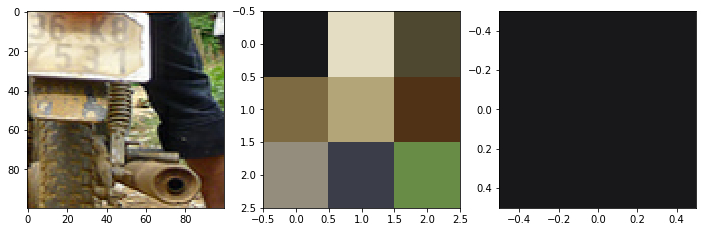

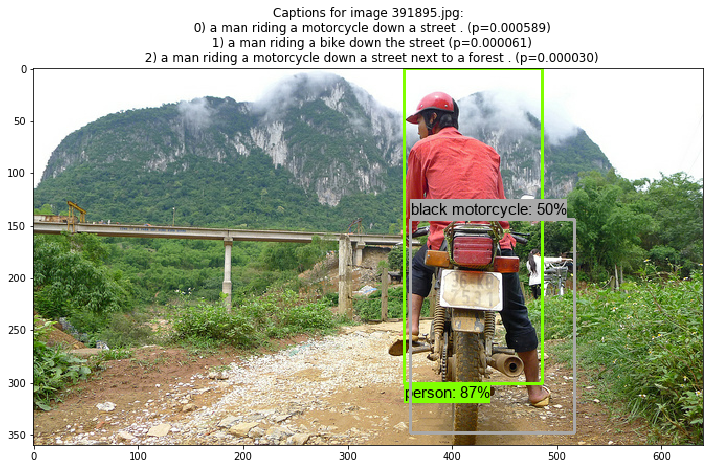

/Users/aghasy/Desktop/tmp/test_images/vnc-:192.168.5.238.jpg


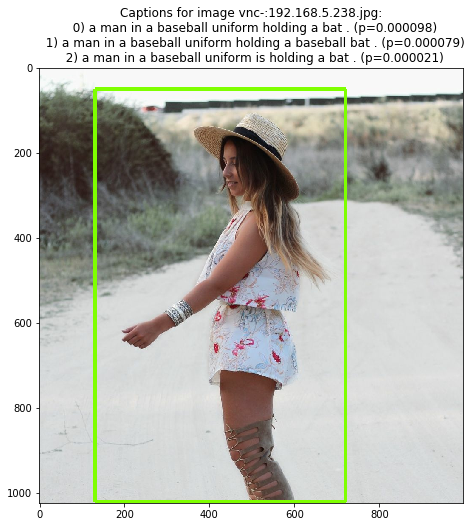

/Users/aghasy/Desktop/tmp/test_images/GettyImages-854756486.jpg
[(7, 1944), (0, 1921), (5, 1508), (6, 1221), (1, 959), (4, 896), (8, 722), (3, 448), (2, 381)]


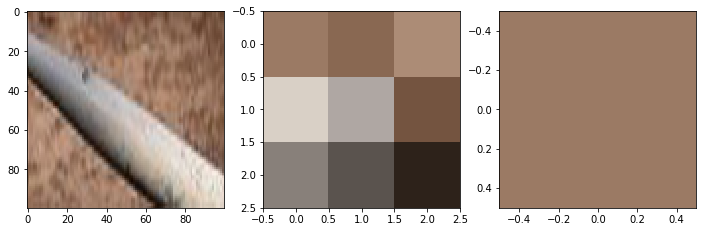

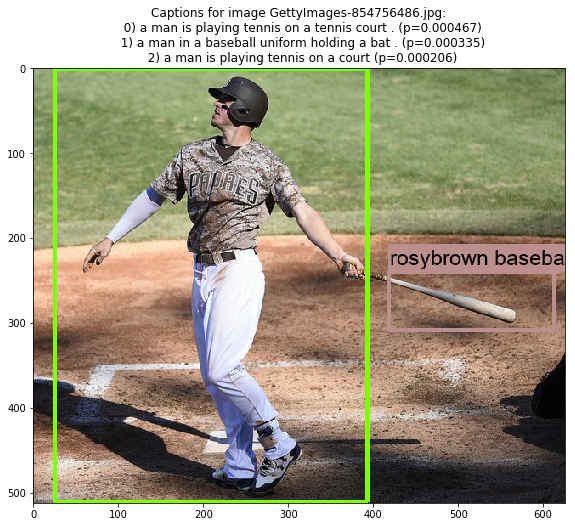

/Users/aghasy/Desktop/tmp/test_images/image-1.jpg
[(5, 4638), (1, 2155), (6, 819), (0, 807), (4, 679), (3, 445), (2, 205), (8, 173), (7, 79)]


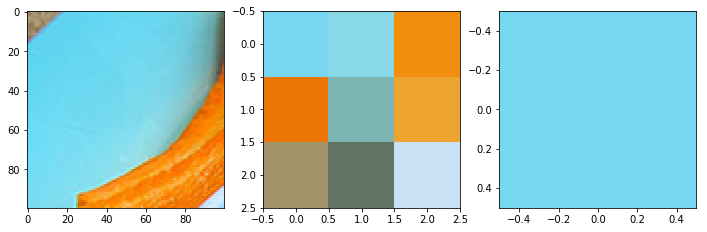

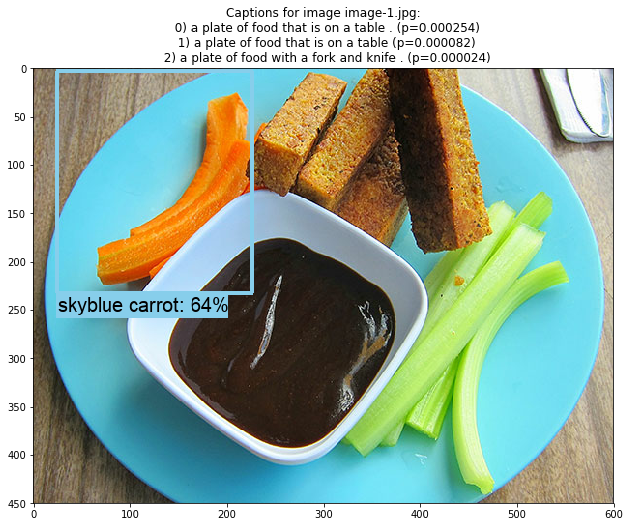

/Users/aghasy/Desktop/tmp/test_images/BB.jpg
[(7, 2195), (6, 1573), (0, 1480), (4, 1428), (1, 1384), (2, 1205), (8, 404), (5, 183), (3, 148)]


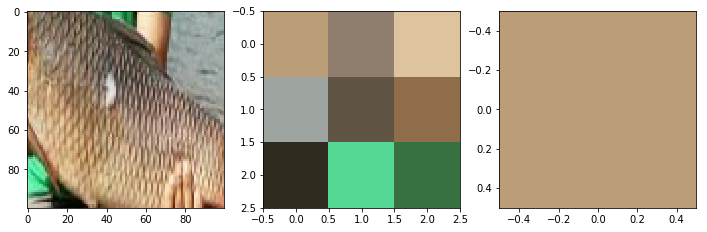

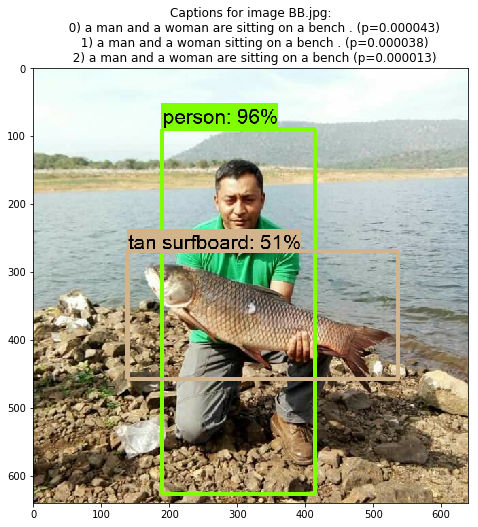

/Users/aghasy/Desktop/tmp/test_images/DSC_0589.jpg
[(6, 2703), (0, 2334), (3, 2158), (4, 1098), (2, 1053), (7, 263), (1, 189), (5, 118), (8, 84)]


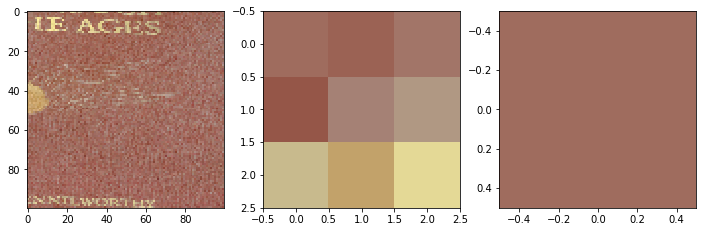

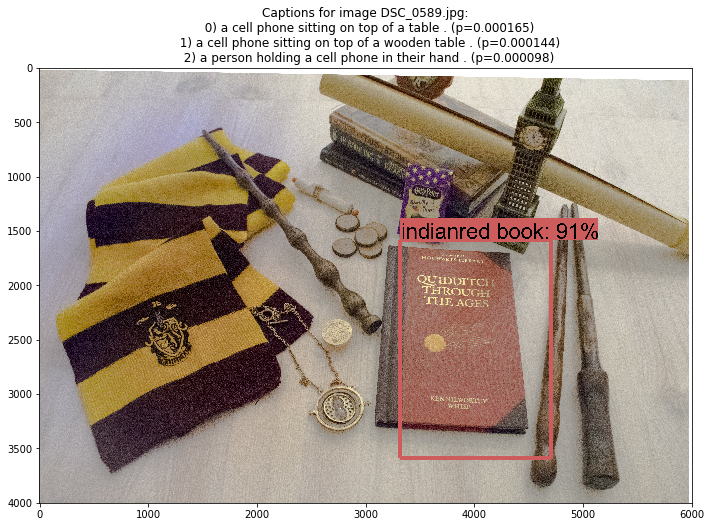

/Users/aghasy/Desktop/tmp/test_images/image-2.jpg


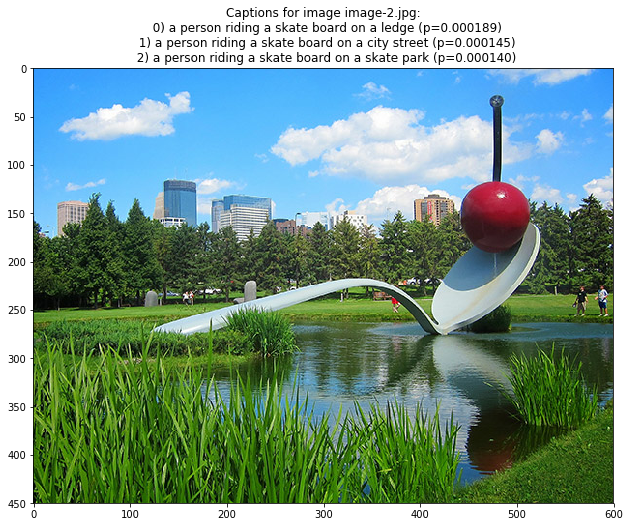

/Users/aghasy/Desktop/tmp/test_images/230144620067202.jpg
[(8, 2006), (0, 1622), (6, 1616), (5, 1197), (2, 1005), (1, 989), (3, 845), (7, 527), (4, 193)]


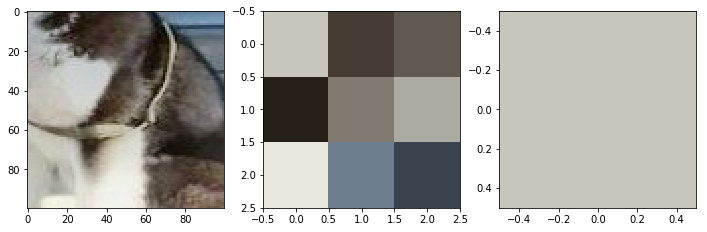

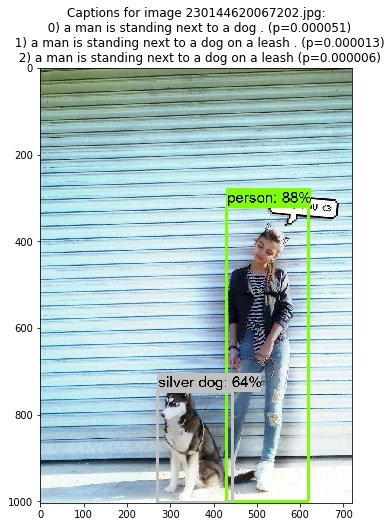

/Users/aghasy/Desktop/tmp/test_images/20150515_235154.jpg


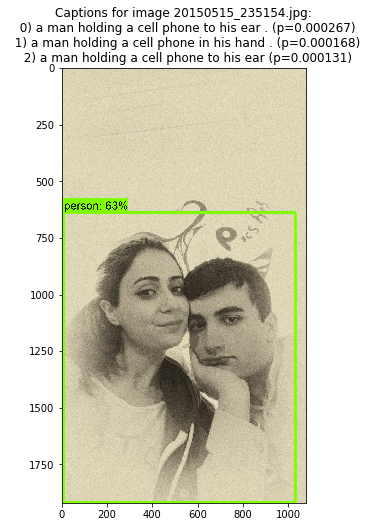

In [147]:
with tf.Session() as sess:
    restore_fn(sess)
    for image_path in TEST_IMAGE_PATHS()[:]:
        print(image_path)
        with open(image_path, 'rb') as content_file:
            content = content_file.read()
        captions = generator.beam_search(sess, content)
        title = "Captions for image %s:" % os.path.basename(image_path)
        for i, caption in enumerate(captions):
            # Ignore begin and end words.
            sentence = [vocab.id_to_word(w) for w in caption.sentence[1:-1]]
            sentence = " ".join(sentence)
            title += "\n  %d) %s (p=%f)" % (i, sentence, math.exp(caption.logprob))
        plt.title(title)
        plt.draw()
        plt.pause(0.001)

In [142]:
x = color_map[0][0]

In [143]:
x.

SyntaxError: invalid syntax (<ipython-input-143-a2885923daf8>, line 1)